<center><h2>Welcome to Rwanda Carbon Prediction Challenge</h2></center>
<figure>
<!-- <center><img src ="https://drive.google.com/uc?export=view&id=1hSOAfRhJ_jo-MZAjq81VYJu5bZNL7EjD" width = "800" height = '500'/> -->

*About the problem*
> The ability to accurately monitor carbon emissions is a critical step in the fight against climate change. Precise carbon readings allow researchers and governments to understand the sources and patterns of carbon mass output. While Europe and North America have extensive systems in place to monitor carbon emissions on the ground, there are few available in Africa.

*Objective of this challenge*
> The objective of this challenge is to create machine learning or a deep learning model using open-source CO2 emissions data (from Sentinel-5P satellite observations) to predict carbon emissions.

These solutions will enable governments and other actors to estimate carbon emission levels across Africa, even in places where on-the-ground monitoring is not possible.



## Table of contents:

1. [Installing and importing libraries](#Libraries)
2. [Loading data](#Data)
3. [Statistical summaries](#Statistics)
4. [Outliers](#Outliers)
5. [Geo Visualisation - EDA](#Geo)
5. [Missing values and duplicates](#Missing)
6. [Date features EDA](#Dates)
7. [Correlations - EDA](#Correlations)
9. [Timeseries visualization - EDA](#Timeseries)


<a name="Libraries"></a>
## 1. Installing and importing libraries


In [4]:
%%capture
# Install relevant libraries
!pip install geopandas folium 

In [5]:
# Import libraries
import pandas as pd
import numpy as np
import random
import os
from tqdm.notebook import tqdm

import geopandas as gpd
from shapely.geometry import Point
import folium

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
pd.options.display.float_format = '{:.5f}'.format
pd.options.display.max_rows = None

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# You can ignore the Shapely GEOS warning :-)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
# Set seed for reproducability
SEED = 2023
random.seed(SEED)
np.random.seed(SEED)

<a name="Data"></a>
## 2. Loading and previewing data

In [7]:
DATA_PATH = '/kaggle/input/playground-series-s3e20'
# Load files
train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
samplesubmission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))

# Preview train dataset
train.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.51000,29.29000,2019,0,-0.00011,0.60302,-0.00007,0.25567,-98.59389,...,3664.43622,61085.80957,2615.12048,15.56853,0.27229,-12.62899,35.63242,-138.78642,30.75214,3.75099
1,ID_-0.510_29.290_2019_01,-0.51000,29.29000,2019,1,0.00002,0.72821,0.00001,0.13099,16.59286,...,3651.19031,66969.47873,3174.57242,8.69060,0.25683,30.35938,39.55763,-145.18393,27.25178,4.02518
2,ID_-0.510_29.290_2019_02,-0.51000,29.29000,2019,2,0.00051,0.74820,0.00038,0.11002,72.79584,...,4216.98649,60068.89445,3516.28267,21.10341,0.25110,15.37788,30.40182,-142.51954,26.19330,4.23138
3,ID_-0.510_29.290_2019_03,-0.51000,29.29000,2019,3,NaN,NaN,NaN,NaN,NaN,...,5228.50774,51064.54734,4180.97332,15.38690,0.26204,-11.29340,24.38036,-132.66583,28.82915,4.30529
4,ID_-0.510_29.290_2019_04,-0.51000,29.29000,2019,4,-0.00008,0.67630,-0.00005,0.12116,4.12127,...,3980.59812,63751.12578,3355.71011,8.11469,0.23585,38.53226,37.39298,-141.50981,22.20461,4.34732


In [8]:
# Preview test dataset
test.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
0,ID_-0.510_29.290_2022_00,-0.51000,29.29000,2022,0,NaN,NaN,NaN,NaN,NaN,...,36022.02734,8472.31348,41047.93750,7472.31348,7.93562,0.24077,-100.11379,33.69704,-133.04755,33.77958
1,ID_-0.510_29.290_2022_01,-0.51000,29.29000,2022,1,0.00046,0.69116,0.00032,0.00000,76.23920,...,48539.73724,6476.14732,54915.70858,5476.14716,11.44844,0.29312,-30.51032,42.40259,-138.63282,31.01238
2,ID_-0.510_29.290_2022_02,-0.51000,29.29000,2022,2,0.00016,0.60511,0.00011,0.07987,-42.05534,...,34133.08047,8984.79570,39006.09375,7984.79570,10.75318,0.26713,39.08736,45.93648,-144.78499,26.74336
3,ID_-0.510_29.290_2022_03,-0.51000,29.29000,2022,3,0.00035,0.69692,0.00024,0.20103,72.16957,...,50854.99108,6014.72406,57646.36837,5014.72412,11.76456,0.30468,-24.46513,42.14042,-135.02789,29.60477
4,ID_-0.510_29.290_2022_04,-0.51000,29.29000,2022,4,-0.00032,0.58053,-0.00018,0.20435,76.19086,...,46594.68514,6849.28048,52896.54187,5849.28039,13.06532,0.28422,-12.90785,30.12264,-135.50012,26.27681


In [9]:
# Preview sample submission file
samplesubmission.head()

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-0.510_29.290_2022_00,81.94000
1,ID_-0.510_29.290_2022_01,81.94000
2,ID_-0.510_29.290_2022_02,81.94000
3,ID_-0.510_29.290_2022_03,81.94000
4,ID_-0.510_29.290_2022_04,81.94000


In [10]:
# Check size and shape of datasets
train.shape, test.shape, samplesubmission.shape

((79023, 76), (24353, 75), (24353, 2))

In [11]:
# Train to test sets ratio
(test.shape[0]) / (train.shape[0] + test.shape[0])

0.23557692307692307

<a name="Statistics"></a>
## 3. Statistical summaries

In [12]:
# Train statistical summary
train.describe(include = 'all')

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
count,79023,79023.00000,79023.00000,79023.00000,79023.00000,64414.00000,64414.00000,64414.00000,64414.00000,64414.00000,...,78539.00000,78539.00000,78539.00000,78539.00000,78539.00000,78539.00000,78539.00000,78539.00000,78539.00000,79023.00000
unique,79023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ID_-0.510_29.290_2019_00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,-1.89107,29.88015,2020.00000,26.00000,0.00005,0.83485,0.00004,0.15842,-7.92587,...,5592.37748,59420.29746,4670.43087,19.13924,0.27146,-10.78483,40.43698,-86.80058,27.92598,81.94055
std,NaN,0.69452,0.81038,0.81650,15.29716,0.00027,0.18538,0.00021,0.07136,64.26337,...,1428.50300,9051.16361,1359.25158,13.54705,0.04943,30.37446,6.42822,37.83727,4.40384,144.29965
min,NaN,-3.29900,28.22800,2019.00000,0.00000,-0.00100,0.24182,-0.00089,0.00000,-179.53706,...,1050.66178,24779.03370,1050.49682,1.84453,0.01770,-102.73973,2.99887,-153.46421,10.81829,0.00000
25%,NaN,-2.45100,29.26200,2019.00000,13.00000,-0.00010,0.70582,-0.00008,0.11053,-56.78238,...,4595.40052,53175.77993,3680.85634,9.97457,0.24145,-30.30917,35.82991,-125.99116,24.68676,9.79800
50%,NaN,-1.88200,29.88300,2020.00000,26.00000,0.00002,0.80912,0.00002,0.16185,-12.44173,...,5573.85431,59332.53255,4621.75517,15.13069,0.27275,-12.67391,41.11963,-84.64435,28.33363,45.59345
75%,NaN,-1.30300,30.47100,2021.00000,39.00000,0.00015,0.94279,0.00012,0.21182,72.05999,...,6542.30364,65663.84268,5572.98322,23.78503,0.30289,9.40220,44.44627,-48.13270,31.49988,109.54959


From the above statistical summary, we can deduce some of the following insights:
 - The train data provided ranges from year *2019 to 2021*
 - Minimum recorded CO2 emissions is *0.32064* and a maximum of *3167.76800*
 - Week of the year starts from 0 to 52
 - The latitude and longitudes ranges show that the regions are mostly within Rwanda 

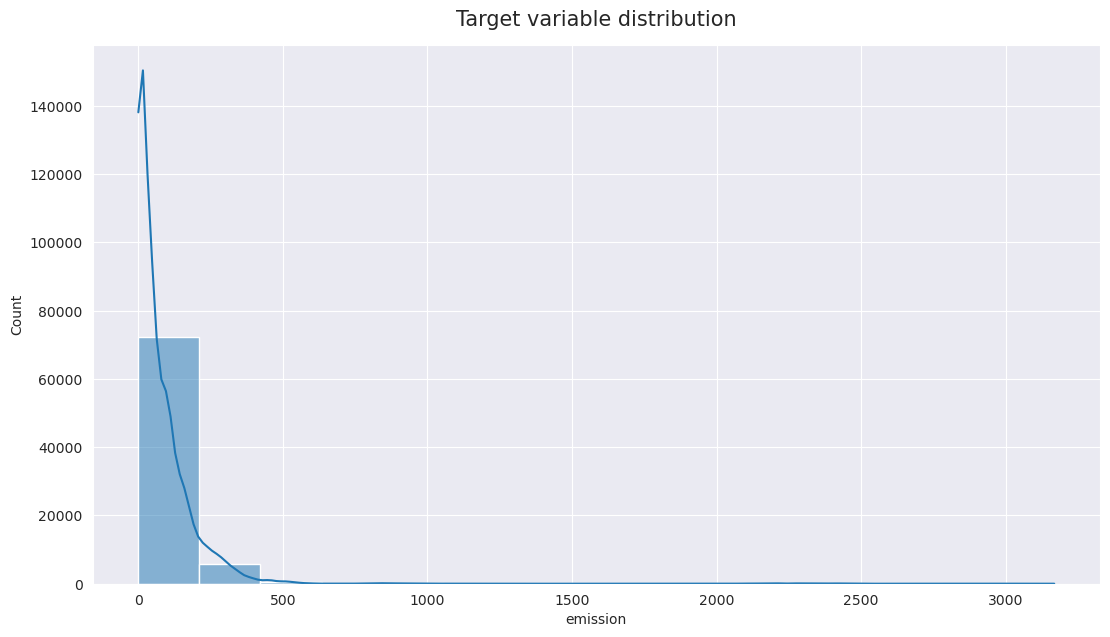

None

10.173825825101622

In [13]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.histplot(train.emission, kde = True, bins = 15)
plt.title('Target variable distribution', y = 1.02, fontsize = 15)
display(plt.show(), train.emission.skew())

The target variable is skewed to the right with a a degree of ~7.

Some of the techniques used to handle skewness include:
- Log transform
- Box-cox transform
- Square root transform
- *etc*

<a name="Outliers"></a>
## 4. Outliers


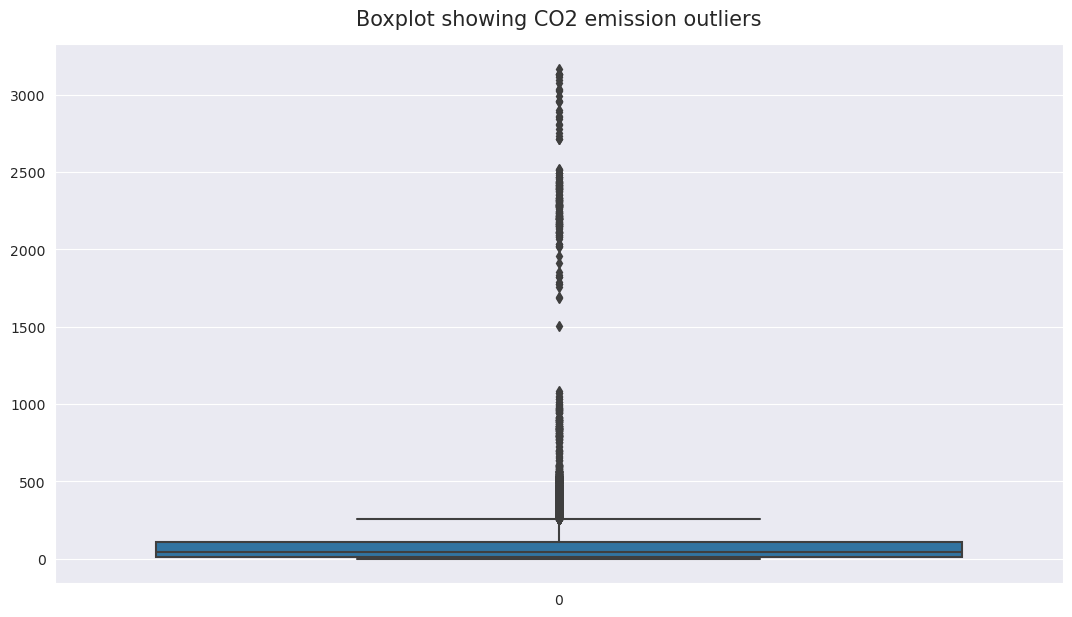

In [14]:
# Plotting boxplot for the CO2 emissions
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.boxplot(train.emission)
plt.title('Boxplot showing CO2 emission outliers', y = 1.02, fontsize = 15)  
plt.show()

Outliers are those data points which differ significantly from other observations present in given dataset.

Suggestions on how to handle outliers:
 - Transforming the outliers by scaling - log transformation, box-cox transformation ...
 - Dropping outliers
 - Imputation by replacing outliers with mean, median ...
 

<a name="Geo"></a>
## 5. Geo Visualisation - EDA

In [15]:
# Combine train and test for easy visualisation
train_coords = train.drop_duplicates(subset = ['latitude', 'longitude'])
test_coords = test.drop_duplicates(subset = ['latitude', 'longitude'])
train_coords['set_type'], test_coords['set_type'] = 'train', 'test'

all_data = pd.concat([train_coords, test_coords], ignore_index = True)
# Create point geometries

geometry = gpd.points_from_xy(all_data.longitude, all_data.latitude)
geo_df = gpd.GeoDataFrame(
    all_data[["latitude", "longitude", "set_type"]], geometry=geometry
)

# Preview the geopandas df
geo_df.head()

,latitude,longitude,set_type,geometry
0,-0.51000,29.29000,train,POINT (29.29000 -0.51000)
1,-0.52800,29.47200,train,POINT (29.47200 -0.52800)
2,-0.54700,29.65300,train,POINT (29.65300 -0.54700)
3,-0.56900,30.03100,train,POINT (30.03100 -0.56900)
4,-0.59800,29.10200,train,POINT (29.10200 -0.59800)


In [16]:
# Create a canvas to plot your map on
all_data_map = folium.Map(prefer_canvas=True)

# Create a geometry list from the GeoDataFrame
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in geo_df.geometry]

# Iterate through list and add a marker for each volcano, color-coded by its type.
i = 0
for coordinates in geo_df_list:
    # assign a color marker for the type set
    if geo_df.set_type[i] == "train":
        type_color = "green"
    elif geo_df.set_type[i] == "test":
        type_color = "orange"

    # Place the markers 
    all_data_map.add_child(
        folium.CircleMarker(
            location=coordinates,
            radius = 1,
            weight = 4,
            zoom =10,
            popup= 
            "Set: " + str(geo_df.set_type[i]) + "<br>"
            "Coordinates: " + str([round(x, 2) for x in geo_df_list[i]]),
            color =  type_color),
        )
    i = i + 1
all_data_map.fit_bounds(all_data_map.get_bounds())
all_data_map

<a name="Missing"></a>
## 6. Missing values and duplicates

In [17]:
# Check for missing values
train.isnull().sum().any(), test.isnull().sum().any() 

(True, True)

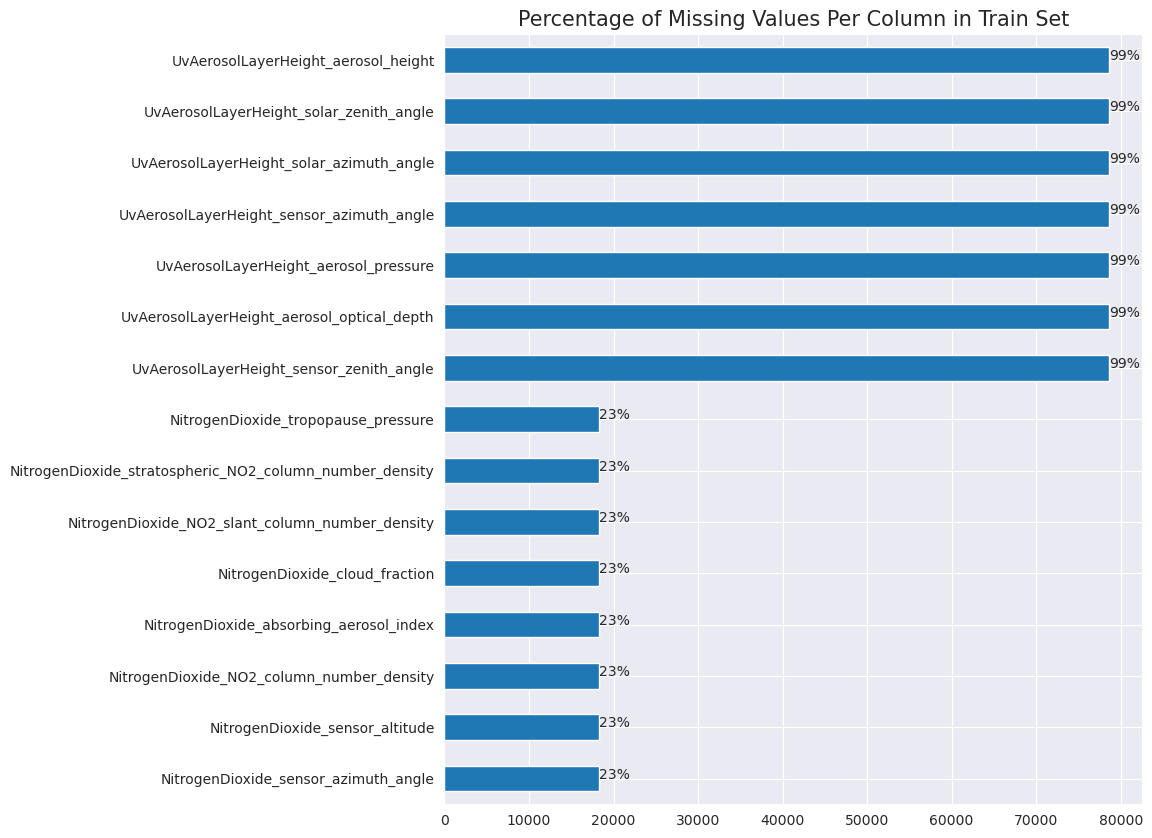

In [18]:
# Plot missing values in train set
ax = train.isna().sum().sort_values(ascending = False)[:15][::-1].plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

Suggestions on how to handle missing values:
 - Fill in missing values with mode, mean, median..
 - Drop Missing datapoints with missing values
 - Fill in with a large number e.g -999999

In [19]:
# Check for duplicates
train.duplicated().any(), test.duplicated().any()

(False, False)

<a name="Dates"></a>
## 7. Date features EDA

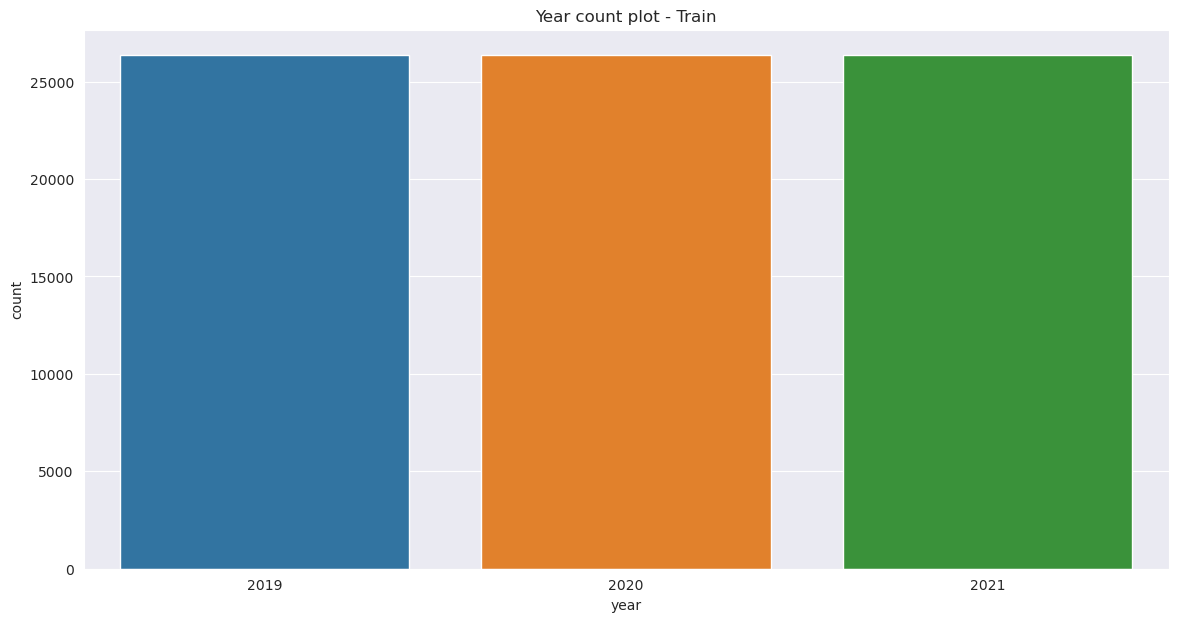

In [20]:
# Year countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'year', data = train)
plt.title('Year count plot - Train')
plt.show()

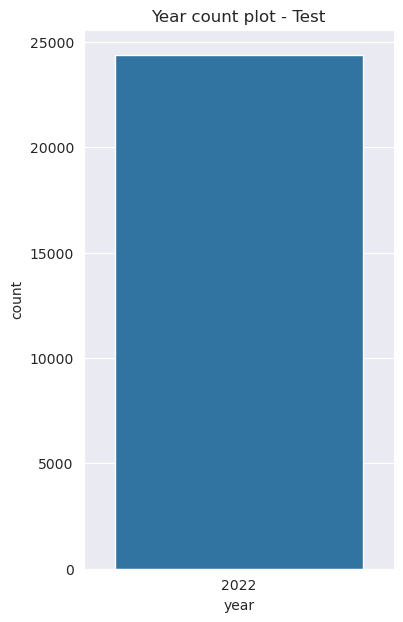

In [21]:
# Year countplot
plt.figure(figsize = (4, 7))
sns.countplot(x = 'year', data = test)
plt.title('Year count plot - Test')
plt.show()

- The number of observations of CO2 emissions are the same across the years (2019, 2020, 2021)
- Year 2022 (in the test set) has fewer number of observations

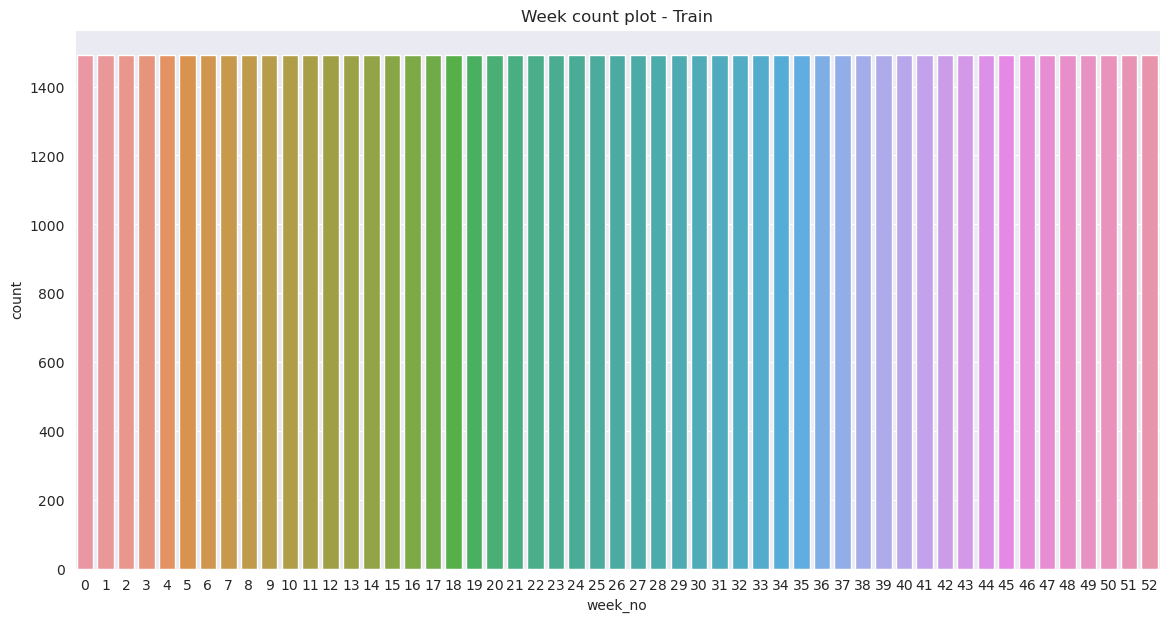

In [22]:
# Week countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'week_no', data = train)
plt.title('Week count plot - Train')
plt.show()

- The number of observations of CO2 emissions are relatively the same across the weeks

In [23]:
train.drop_duplicates(subset = ['year', 'week_no']).groupby(['year'])[['week_no']].count()

,week_no
year,
2019,53
2020,53
2021,53


<a name="Correlations"></a>
## 8. Correlations - EDA

In [24]:
# Top 20 correlated features to the target
top20_corrs = abs(train.corr()['emission']).sort_values(ascending = False).head(20)
top20_corrs

emission                                                   1.00000
longitude                                                  0.10275
UvAerosolLayerHeight_aerosol_height                        0.06901
UvAerosolLayerHeight_aerosol_pressure                      0.06814
Cloud_surface_albedo                                       0.04659
CarbonMonoxide_H2O_column_number_density                   0.04322
CarbonMonoxide_CO_column_number_density                    0.04133
Formaldehyde_tropospheric_HCHO_column_number_density_amf   0.04026
UvAerosolLayerHeight_aerosol_optical_depth                 0.04016
UvAerosolLayerHeight_sensor_azimuth_angle                  0.03514
NitrogenDioxide_solar_azimuth_angle                        0.03342
Formaldehyde_tropospheric_HCHO_column_number_density       0.03333
SulphurDioxide_solar_azimuth_angle                         0.03234
Formaldehyde_solar_azimuth_angle                           0.03081
NitrogenDioxide_sensor_altitude                            0.0

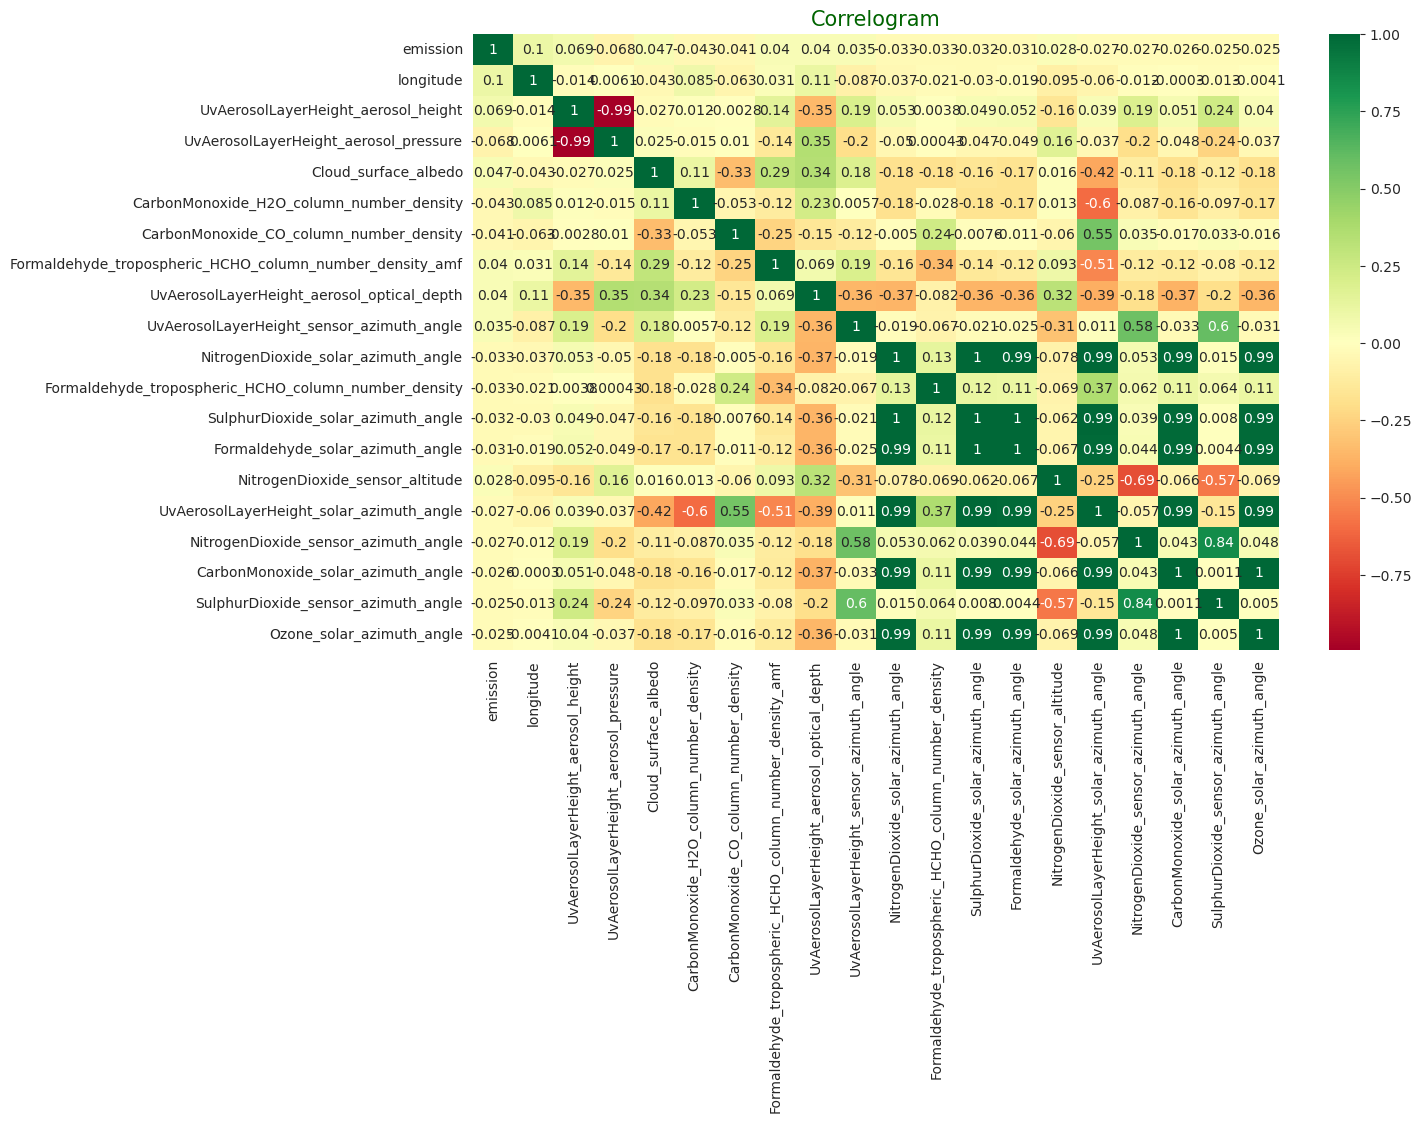

In [25]:
# Quantify correlations between features
corr = train[list(top20_corrs.index)].corr()
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

<a name="Timeseries"></a>
## 9. Timeseries visualization - EDA

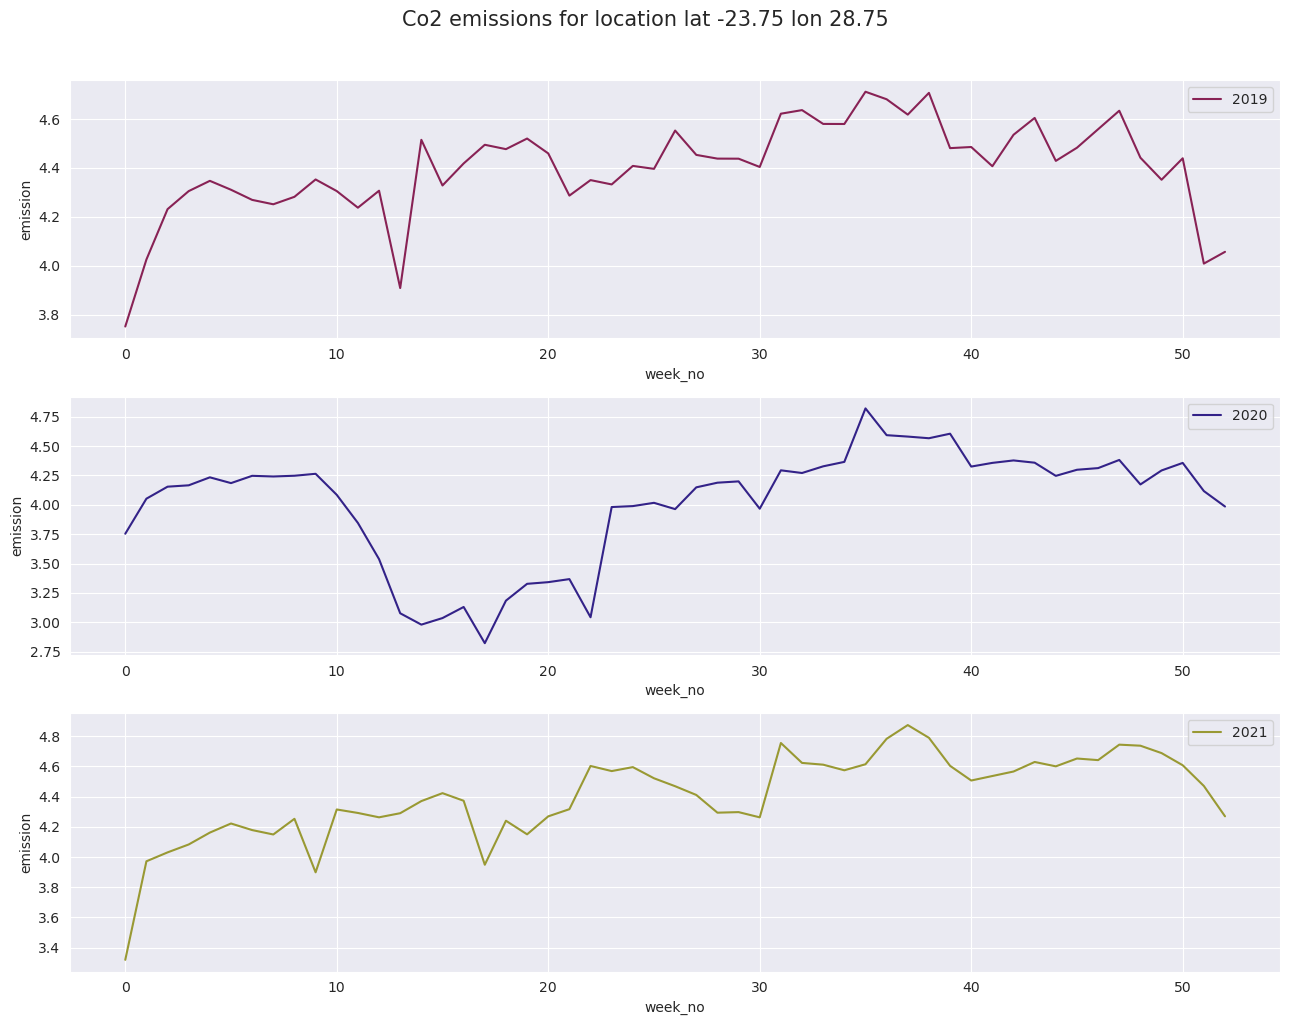

In [26]:
# Sample a unique location and visualize its emissions across the years
train.latitude, train.longitude = round(train.latitude, 2), round(train.longitude, 2)
sample_loc = train[(train.latitude == -0.510) & (train.longitude == 29.290)]

# Plot a line plot
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (13, 10))
fig.suptitle('Co2 emissions for location lat -23.75 lon 28.75', y=1.02, fontsize = 15)

for ax, data, year, color, in zip(axes.flatten(), sample_loc, sample_loc.year.unique(), ['#882255','#332288', '#999933' , 'orangered']):
  df = sample_loc[sample_loc.year == year]
  sns.lineplot(x=df.week_no,y= df.emission, ax = ax, label = year, color = color)
plt.legend()
plt.tight_layout()

### Now that you've explored the features (and seen the important cyclical nature of the data), check out the [Getting Started: Modeling](https://www.kaggle.com/inversion/getting-started-modeling/edit) notebook